In [1]:
import operator
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from performance_profile import check_if_minimized
from plotting_utils import (
  METRIC_FMT,
  PLOT_STYLE,
  clean_results,
  read_data_from_logs,
)
from tueplots import bundles, figsizes

%matplotlib widget

/home/frank/anaconda3/envs/algoperf_pt/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
SELF_TUING = True

log_path = "../../submissions_algorithms_v0.5/logs/algoperf_scoring_v05/"
if SELF_TUING:
  log_path = os.path.join(log_path, "self_tuning")
else:
  log_path = os.path.join(log_path, "external_tuning")

full_results = read_data_from_logs(log_path)
clean_results_df = clean_results(full_results)

Reading data for submission: prize_qualification_baseline
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_i

In [26]:
def get_best_trial_index(workload_df,
                         validation_metric,
                         validation_target=None):
  """Get the eval index in which a workload reaches the target metric_col.

  Args:
    workload_df: A subset of a submission's trials DataFrame that
      includes only the trials in a single workload.
    metric_col: Name of array column in workload_df (e.g. `validation/l1_loss`).
    target: Target value for metric_col.

  Returns:
    Tuple of trial index and time index where the workload reached the target
      metric_col. Return (-1, -1) if not reached.
  """
  is_minimized = check_if_minimized(validation_metric)
  validation_series = workload_df["performance"]
  validation_series = validation_series[validation_series != np.nan]

  op = operator.le if is_minimized else operator.ge
  validation_target_reached = validation_series.apply(
      lambda x: op(x, validation_target))
  target_reached = pd.Series(validation_target_reached)

  # Remove trials that never reach the target
  target_reached = target_reached[target_reached.apply(np.any)]

  # If no trials reach the target return the trial with the best performance
  if len(target_reached) == 0:
    best_validation_performance = validation_series.apply(np.max)
    trial = best_validation_performance.idxmin(
    ) if is_minimized else best_validation_performance.idxmax()
    return trial, -1
  # Else, return the eval index of the earliest point the target is reached.
  else:
    index_reached = target_reached.apply(np.argmax)
    trial = index_reached.idxmin()
    return trial, index_reached[trial]


def plot_workload_results(df, ax, performance_target, performance_metric):
  # display(df)

  # For each study check trials
  for study, group in df.groupby('study'):
    # Get trial and time index that reaches target
    trial_idx, time_idx = get_best_trial_index(
          group, performance_metric, performance_target)

    # # Iterate through each row of the DataFrame
    # for index, row in df.iterrows():
    #   # Extract the runtime and performance lists
    runtime = group['runtime'].loc[trial_idx]
    performance = group['performance'].loc[trial_idx]

    # Create a line plot for the current row
    study_name = group['study'].loc[trial_idx].replace("_", " ").capitalize()
    trial_name = group['trial'].loc[trial_idx].replace("_", " ").capitalize()
    ax.plot(
        runtime,
        performance,
        label=f"{study_name}, {trial_name}",
        lw=1,
        ls="--" if time_idx == -1 else "-")


def plot_submission(submission, workload, results_df):

  with plt.rc_context(
      {**bundles.iclr2024(), **figsizes.iclr2024(height_to_width_ratio=1)}):
    fig, ax = plt.subplots()

    # Select the results of the chosen submission
    df = results_df[submission]
    # Select all rows of the chosen workload
    df = df[df["workload"] == workload]

    # Compute relevant information
    runtime_budget = 3 * df["runtime_budget"].unique(
    )[0] if SELF_TUING else df["runtime_budget"].unique()[0]
    performance_target = df["performance_target"].unique()[0]
    performance_metric = df['validation_metric'].unique()[0]
    performance_metric_clean = performance_metric.split("/")[-1]

    plot_workload_results(df, ax, performance_target, performance_metric)

    # Style the plot
    x_lims = [0, runtime_budget]
    y_lims = [0.3, performance_target]
    ax_lims_push_perc = 0.03
    ax.set_xlabel("Runtime")
    ax.set_ylabel(METRIC_FMT[performance_metric_clean])
    ax.set_yscale("log")
    ax_lims_push = [
        ax_lims_push_perc * (x_lims[1] - x_lims[0]),
        ax_lims_push_perc * (y_lims[1] - y_lims[0]),
    ]
    ax.set_xlim(
        left=x_lims[0] - ax_lims_push[0], right=x_lims[1] + ax_lims_push[0])
    ax.set_ylim(bottom=y_lims[0], top=y_lims[1] + ax_lims_push[1])

    # Vertical line for the runtime budget
    ax.axvline(runtime_budget, color="gray", linestyle="--", linewidth=1)
    # Horizontal line for the performance target
    ax.axhline(performance_target, color="gray", linestyle="--", linewidth=1)
    if submission.endswith("_self"):
      submission = submission[:-5]
    elif submission.endswith("_ext"):
      submission = submission[:-4]

    ax.set_title(
        f"{workload.replace('_', ' ').capitalize()} - {PLOT_STYLE[submission]['label']}"
    )

    plt.legend()

    plt.show()

/tmp/ipykernel_13794/918461769.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


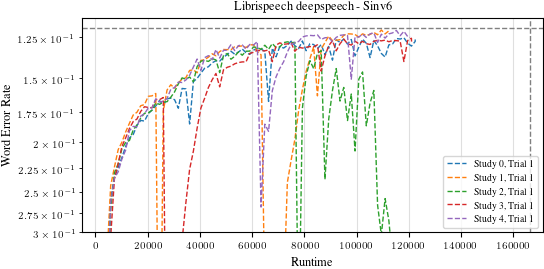

In [31]:
plot_submission(
    "sinv6", "librispeech_deepspeech", results_df=clean_results_df)

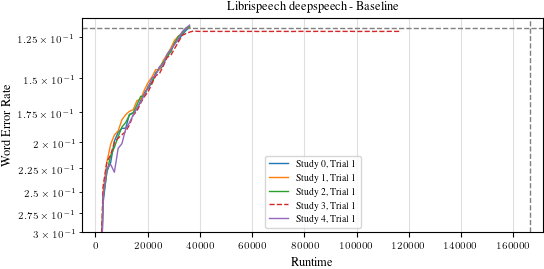

In [30]:
plot_submission(
    "prize_qualification_baseline", "librispeech_deepspeech", results_df=clean_results_df)

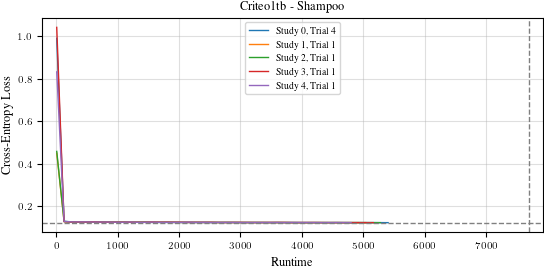

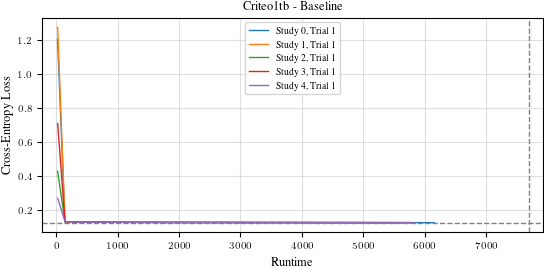

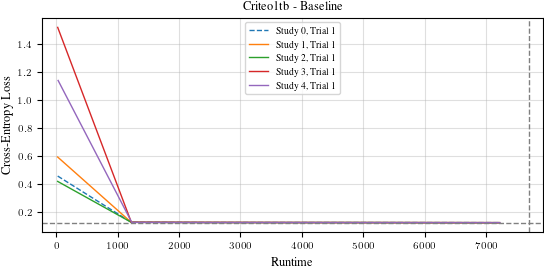

IndexError: index 0 is out of bounds for axis 0 with size 0

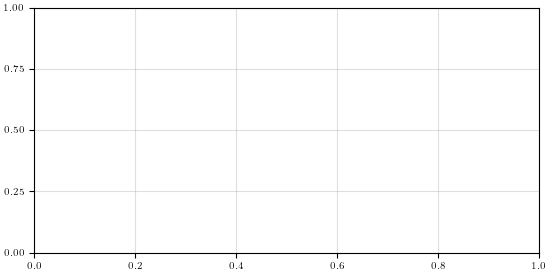

In [210]:
def plot_all_subs(workload, results):
  for sub in results:
    plot_submission(sub, workload, results)


plot_all_subs(workload="criteo1tb", results=clean_results_df)

In [211]:
# Get column names
df = full_results["shampoo_submission"]

for workload, group in df.groupby('workload'):
  print(workload)
  group['final_global_step'] = group['global_step'].apply(lambda x: x[-1])
  print(group['final_global_step'].max())

#

criteo1tb_embed_init_pytorch
1356
criteo1tb_pytorch
10666
fastmri_pytorch
34139
fastmri_tanh_pytorch
33325
imagenet_resnet_large_bn_init_pytorch
170047
imagenet_resnet_pytorch
170394
imagenet_vit_pytorch
186666
librispeech_conformer_layernorm_pytorch
80000
librispeech_conformer_pytorch
80000
librispeech_deepspeech_pytorch
48000
ogbg_model_size_pytorch
55535
ogbg_pytorch
55434
wmt_glu_tanh_pytorch
119844
wmt_pytorch
126136


In [218]:
df = clean_results_df["shampoo_submission"]
df['last_runtime'] = df['runtime'].apply(lambda x: x[-1])
df[df['workload'] == 'criteo1tb']


,workload,study,trial,time_to_target,runtime,performance,validation_metric,performance_target,runtime_budget,last_runtime
25,criteo1tb,study_0,trial_1,5765.915496,"[5.748035669326782, 125.35267615318298, 245.72...","[0.3627596708480587, 0.1293394525200906, 0.127...",validation/loss,0.123735,7703,5765.915496
26,criteo1tb,study_0,trial_2,inf,"[5.786920547485352, 125.46807837486269, 245.99...","[1.701615316082086, 0.1309356529993274, 0.1280...",validation/loss,0.123735,7703,7696.499401
27,criteo1tb,study_0,trial_3,inf,[5.686947345733643],[0.373768151810185],validation/loss,0.123735,7703,5.686947
28,criteo1tb,study_0,trial_4,5407.026378,"[5.294373989105225, 124.88906693458556, 245.33...","[0.9889934806983895, 0.1299614809134834, 0.127...",validation/loss,0.123735,7703,5407.026378
29,criteo1tb,study_0,trial_5,5523.992123,"[5.419969081878662, 125.10971164703368, 244.80...","[0.5742398724946992, 0.1303307618654784, 0.128...",validation/loss,0.123735,7703,5523.992123
30,criteo1tb,study_1,trial_1,5042.694446,"[5.410980939865112, 125.48390102386476, 245.10...","[0.449862602638554, 0.128564468198752, 0.12711...",validation/loss,0.123735,7703,5042.694446
31,criteo1tb,study_1,trial_2,inf,"[5.398597717285156, 125.18861889839172, 245.02...","[0.5395141798211265, 0.1298571757109912, 0.127...",validation/loss,0.123735,7703,6967.663623
32,criteo1tb,study_1,trial_3,inf,[5.970555782318115],[2.2689186981938976],validation/loss,0.123735,7703,5.970556
33,criteo1tb,study_1,trial_4,6603.491724,"[5.638784646987915, 125.63818979263306, 246.03...","[0.7598445514214001, 0.130713672222465, 0.1280...",validation/loss,0.123735,7703,6603.491724
34,criteo1tb,study_1,trial_5,6248.266382,"[5.804599046707153, 125.62641549110413, 246.13...","[0.5739911258058105, 0.1324518689259378, 0.128...",validation/loss,0.123735,7703,6248.266382
